In [1]:
#conda install -c conda-forge ase

In [2]:
#conda update -n base -c defaults conda

In [3]:
#conda install -c conda-forge nglview

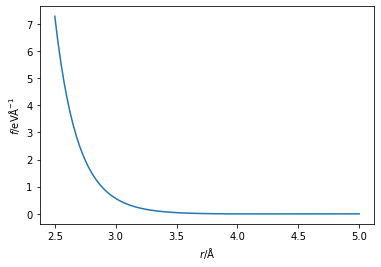

(-0.2, 0.2)

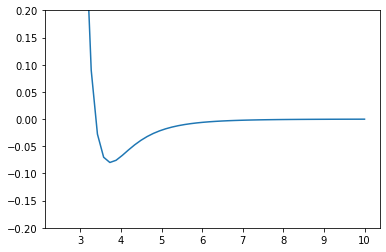

In [1]:
import numpy as np
from ase.io.trajectory import Trajectory        #use google doc to figure out what this is might need to install something 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf   #for the autocorellation function

epsilon=0.1
sigma=3.0
ri=0            #Do I add the other particles in here? Do I do it manually or individual entries?
rj=3.0
rij=abs(rj-ri)        #ijklmo could denote them? n could mean something else 
rij

def u(r, epsilon, sigma):  #calculates the force of the interaction for a lenard jones potential where 
    
  
    return 48 * epsilon * np.power(  #r is the distance between 2 particles (Å) epsilon is the potential energy at equilibrium 
        sigma, 12) / np.power(            #sigma is the distance for which the potential energy is zero
        r, 13) - 24 * epsilon * np.power(      #The force is in eV/Å 
        sigma, 6) / np.power(r, 7)
    
r = np.linspace(2.5, 5, 100)
plt.plot(r, u(r, 0.0103, 3.4))
plt.xlabel(r'$r$/Å')
plt.ylabel(r'$f$/eVÅ$^{-1}$')
plt.show()


r=np.linspace(2.5,10)

fr=-4*epsilon*(((-12)*sigma**12/r**13)+6*sigma**6/r**7)  #derivitive of u
fr                                                       #This went wrong somewhere was working before  (NOW WORKING????)

plt.plot(r,fr)
plt.ylim(-0.2,0.2)

In [22]:
def energyij(model, atomi, atomj):                     
                                        #lenard jones potential energy

    r=np.linalg.norm(model['atoms'][atomi].position-model['atoms'][atomj].position)
    u=4*epsilon*((sigma/r)**12-(sigma/r)**6)
    return u

def forceij(model, atomi, atomj):

    r=np.linalg.norm(model['atoms'][atomi].position-model['atoms'][atomj].position)
    
    dir=(model['atoms'][atomi].position-model['atoms'][atomj].position)/r
    
    fr=-4*epsilon*(12*sigma**12*r**(-13)-6*sigma**6*r**(-7))
    return -fr*dir, fr*dir



#we need to store everything in a dictionary??

In [31]:
from ase import Atoms
import numpy as np
nsteps=2000
dt=0.1       #is this small enough??? earlier it was 0.01
mass=1.0
d=3.2       #what is d?
output_freq=1
#atoms=Atoms('Ar6', positions=[(0.0,0.0,0.0),(0.0,0.0,d),(0.0,0.0,2*d),(0.0,0.0,3*d),(0.0,0.0,4*d),(0.0,0.0,5*d)])

atoms=Atoms('Ar2', positions=[(0.0,0.0,0.0),(0.0,0.0,d)])
natoms=len(atoms)
model=dict(natoms=natoms,
           atoms=atoms,
           vel=np.zeros((natoms, 3)), #why 3???
           forcestp1=np.zeros((natoms,3)),
           forcest=np.zeros((natoms,3)),
           pot_energy=[],
           KE=[],
           traj=[], 
           potential=energyij,
           temp_pos=np.zeros((natoms,3)),
           temp_vel=np.zeros((natoms,3)),
           output_freq=output_freq,
           integrator='vverlet')

#where do we define Atoms???

In [32]:
atoms[1]

Atom('Ar', [0.0, 0.0, 3.2], index=1)

In [33]:
def integrate(model):
    KE = 0
    if model['integrator'] == 'Euler':
        pot_energy = calcForces(model)
        model['atoms'].positions += model['vel'][:]*dt + 0.5*model['forcestp1'][:]/mass*dt**2
        model['vel'][:] += model['forcestp1'][:]/mass*dt

    elif model['integrator'] == 'vverlet':
        model['forcest'] =  np.copy(model['forcestp1'])
        model['atoms'].positions += model['vel'][:]*dt + 0.5*model['forcest'][:]/mass*dt**2
        pot_energy = calcForces(model)
        model['vel'][:] += 0.5*(model['forcest'][:] + model['forcestp1'][:])/mass*dt            

    else:
        print('no known integrator! falling back on Euler')
        pot_energy = calcForces(model)
        model['atoms'].positions += model['vel'][:]*dt + 0.5*model['forcestp1'][:]/mass*dt**2
        model['vel'][:] += model['forcestp1'][:]/mass*dt
    
    # fancy way of calculating the KE, not sure if it is faster
    #KE = np.sum(np.array([np.dot(model['vel'][i],model['vel'][i]) for i in range(model['natoms'])]))
    
    for i in range(model['natoms']):
        KE += np.dot(model['vel'][i],model['vel'][i])

    return pot_energy, KE

In [34]:
def calcForces(model):
    energy=0
    
    model['forcestp1'][:]=0.0            #reset the force at each step
    
    for atomi in range (model['natoms']):     #need to avoid double counting
        for atomj in range (atomi+1, natoms):
            energy+=model['potential'](model,atomi,atomj)
            fi, fj = forceij(model, atomi, atomj)
            model['forcestp1'][atomi]+=fi
            model['forcestp1'][atomj]+=fj
    #print(model['forcestp1'])        
    return energy        

In [35]:
calcForces(model)

for step in range (nsteps):
    pot_energy, KE= integrate(model)
    
    model['pot_energy'].append(pot_energy)
    model['KE'].append(0.5*mass*KE)
    
    if not step%model['output_freq']:
        model['traj'].append(np.copy(model['atoms'].positions))
        
#return         #what do we return?? pot_energy and KE??

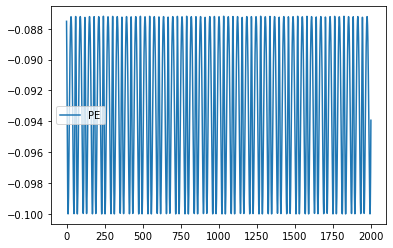

In [36]:
import numpy as np
from ase.io.trajectory import Trajectory        #use google doc to figure out what this is might need to install something 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

#plt.plot(np.array(model['KE']), label='KE')
plt.plot(np.array(model['pot_energy']), label='PE')

plt.legend()

In [9]:
import nglview as nv

ModuleNotFoundError: No module named 'nglview'

In [ ]:
#need to export and then reimport at ASE traj???????????

mytraj=Trajectory('mytraj.traj', mode='w')

for traj in model['traj']:
    atoms.positions=traj
    mytraj.write(atoms=atoms)
    
mytraj.close()
myreadtraj=Trajectory('mytraj.traj',mode='r')

In [ ]:
nv.show_asetraj(myreadtraj) 

In [ ]:
#these arrays will help for the larger system of 6 particles then use acceleration and velocity calculation functions to 
#fill them 

#Dont know where this comes in 

dt = 0.001         #is this a good and stable time step? Explain   some say nanoseconds or less 

 

# set up some empty arrays to store the trjectory variables, will need 5 more of each??

xitraj = [] 

vitraj = [] 

xjtraj = [] 

vjtraj = [] 

rijtraj = [] 

Fitraj = [] 

Fjtraj = [] 

E_LJ = [] 

E_LJ.append(energy_at_rij(ri, rj))     

xitraj.append(ri) 

xjtraj.append(rj) 

rijtraj.append(rj) 

vitraj.append(vi) 

vjtraj.append(vj)     

Fitraj.append(Fi) 

Fjtraj.append(Fj)     

 

for step in range(5000): 

    Fi, Fj = calc_forces(ri, rj) 

    ri = ri + vi*dt + 0.5*Fi*dt**2 

    rj = rj + vj*dt + 0.5*Fj*dt**2 

    vi = vi + Fi*dt 

    vj = vj + Fj*dt 

    E_LJ.append(energy_at_rij(ri, rj)) 

    xitraj.append(ri) 

    xjtraj.append(rj) 

    rijtraj.append(abs(rj-ri)) 

    vitraj.append(vi) 

    vjtraj.append(vj) 

    Fitraj.append(Fi) 

    Fjtraj.append(Fj)  
    

In [ ]:
#Taylor expansion of potential energy about x=0  where would this sytem be about?

T_Exp=U(0)+1/2*dU/dx(0)*x**2+1/3*dU**2/dx**2(0)*x**3

#compare to the vibrational frwquency, should be similar  